<h1>A. Data Collection & Exploration

<h2>Import libraries

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp
from pylift.eval import UpliftEval
from sklearn.cluster import KMeans
from statistics import mean
import sklearn.metrics

<h2>Import dataset

In [2]:
df_data = pd.read_csv('HR_comma_sep.csv')
df_data.index.name = "id"
df_model = df_data.copy()

<h2>Data exploration

In [3]:
pd.options.display.max_columns=100
df_model.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<h2>Define Cols

In [4]:
#choose the single dependent variable (Positive Outcome)
treat = 'promotion_last_5years'

In [5]:
#choose the treatment variable
target = "left"

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


<h2>Check N-uniques for non-categorical data

In [7]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype != "object"]
numbers = [[obj,df_data[obj].nunique()] for obj in object_cols]
numbers_data = pd.DataFrame(numbers, columns = ['column', 'N-unique']) 

In [8]:
numbers_data.sort_values(by='N-unique',ascending=False)

,column,N-unique
3,average_montly_hours,215
0,satisfaction_level,92
1,last_evaluation,65
4,time_spend_company,8
2,number_project,6
5,Work_accident,2
6,left,2
7,promotion_last_5years,2


<h2>Define Columns to Cluster</h2>
Define column to cluster with high amount of N-Uniques

In [9]:
#choose a column with hiearchy to be label encoded
cluster_cols=['average_montly_hours']

<h2>Check uniques for categorical data

In [10]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_data[obj].unique():
        print("{} {}".format(unique,sum(df_data[obj] == unique)))


 Department
sales 4140
accounting 767
hr 739
technical 2720
support 2229
management 630
IT 1227
product_mng 902
marketing 858
RandD 787

 salary
low 7316
medium 6446
high 1237


<h2>Rename Data

<h2>Invert Target Value(Churn to Stay)

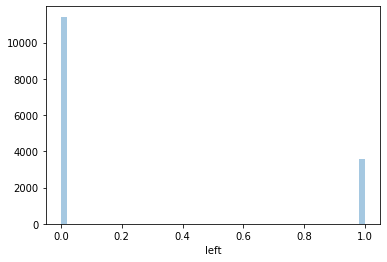

In [11]:
sns.distplot(a=df_model.left, hist=True,kde=False)

In [12]:
df_model = df_model.rename(columns={"left": "Stay"})
df_model.Stay = df_model.Stay.replace({0:1, 1:0})

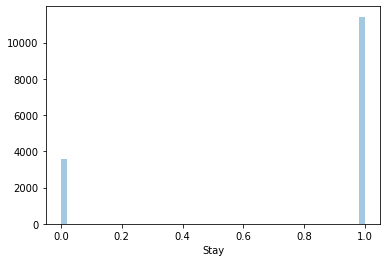

In [13]:
sns.distplot(a=df_model.Stay, hist=True,kde=False)

In [14]:

# df_model.OverTime.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)

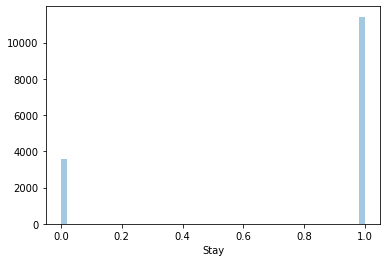

In [15]:
sns.distplot(a=df_model.Stay, hist=True,kde=False)

<h2>Define columns to Label encode

In [16]:
df_model[object_cols].head()

,Department,salary
id,,
0,sales,low
1,sales,medium
2,sales,medium
3,sales,low
4,sales,low


In [17]:
#choose a column with wide range to be clusterred
label_cols = ['salary']

<h1>B. Data Preprocessing

<h2>Label encoding hierarchy columns

In [18]:
#Label encoding
print("label encoding columns:",label_cols)
label_encoder = LabelEncoder()
for col in label_cols:
    df_model[col] = label_encoder.fit_transform(df_data[col])
    df_model[col] = label_encoder.transform(df_data[col])
print(">>label encoding finished")
df_model[label_cols].head()

label encoding columns: ['salary']
>>label encoding finished


,salary
id,
0,1
1,2
2,2
3,1
4,1


<h2>Data cleaning

In [19]:
df_model.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Stay,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,0,0,sales,1
1,0.80,0.86,5,262,6,0,0,0,sales,2
2,0.11,0.88,7,272,4,0,0,0,sales,2
3,0.72,0.87,5,223,5,0,0,0,sales,1
4,0.37,0.52,2,159,3,0,0,0,sales,1


In [20]:
#DROP unused columns
# df_model = df_model.drop(['Over18','StandardHours','StockOptionLevel','EmployeeCount','EmployeeNumber'],axis=1)

<h2>Cluster & One Hot Encoding

In [21]:
# #function to order clusters
# def order_cluster(cluster_field_name, target_field_name,df,ascending):
#     new_cluster_field_name = 'new_' + cluster_field_name
#     df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
#     df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
#     df_new['index'] = df_new.index
#     df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
#     df_final = df_final.drop([cluster_field_name],axis=1)
#     df_final = df_final.rename(columns={"index":cluster_field_name})
#     return df_final

In [22]:
# #preparing float columns to cluster
# print('Clustering columns:',cluster_cols)
# #creating the clusters
# for col in cluster_cols:
#     col_cluster = col + "_cluster"
#     kmeans = KMeans(n_clusters=5)
#     kmeans.fit(df_model[[col]])
#     df_model[col_cluster] = kmeans.predict(df_model[[col]])
#     #order the clusters
#     df_model = order_cluster(col_cluster, col, df_model, True)
# print('>>Cluster succeeded!')
#dropping columns that have been clustered
df_model = df_model.drop(cluster_cols,axis=1)

#one hot encoding the rest columns
dummies = pd.get_dummies(df_model)
print("\nOne Hot Encoding:",dummies.columns.values)
df_model = dummies
print('>>One Hot Encoding succeeded!')


One Hot Encoding: ['satisfaction_level' 'last_evaluation' 'number_project'
 'time_spend_company' 'Work_accident' 'Stay' 'promotion_last_5years'
 'salary' 'Department_IT' 'Department_RandD' 'Department_accounting'
 'Department_hr' 'Department_management' 'Department_marketing'
 'Department_product_mng' 'Department_sales' 'Department_support'
 'Department_technical']
>>One Hot Encoding succeeded!


<h2>Categorizing target class

Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull!


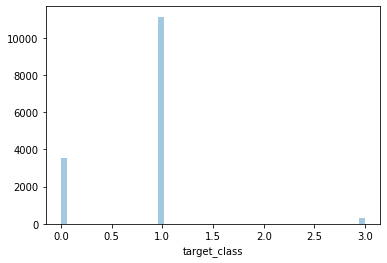

In [23]:
print("Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_model['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_model.loc[(df_model[treat] == 0) & (df_model.Stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_model.loc[(df_model[treat] == 1) & (df_model.Stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_model.loc[(df_model[treat] == 1) & (df_model.Stay > 0),'target_class'] = 3 #TR

print(">>Categorizing successfull!")
sns.distplot(a=df_model.target_class, kde=False)

<h2>Explore data Correlation

In [24]:
#measure the correlation of Employee who stay
pd.options.display.max_rows=100
correlation = df_model.corr(method ='pearson') 
correlation.Stay.sort_values() * 100

time_spend_company        -14.482217
Department_hr              -2.824875
number_project             -2.378719
Department_technical       -2.007610
Department_accounting      -1.520115
Department_support         -1.070012
Department_sales           -0.992341
last_evaluation            -0.656712
Department_marketing        0.085930
salary                      0.129372
Department_IT               1.092483
Department_product_mng      1.102915
Department_management       4.603539
Department_RandD            4.659565
promotion_last_5years       6.178811
Work_accident              15.462163
satisfaction_level         38.837498
target_class               83.881348
Stay                      100.000000
Name: Stay, dtype: float64

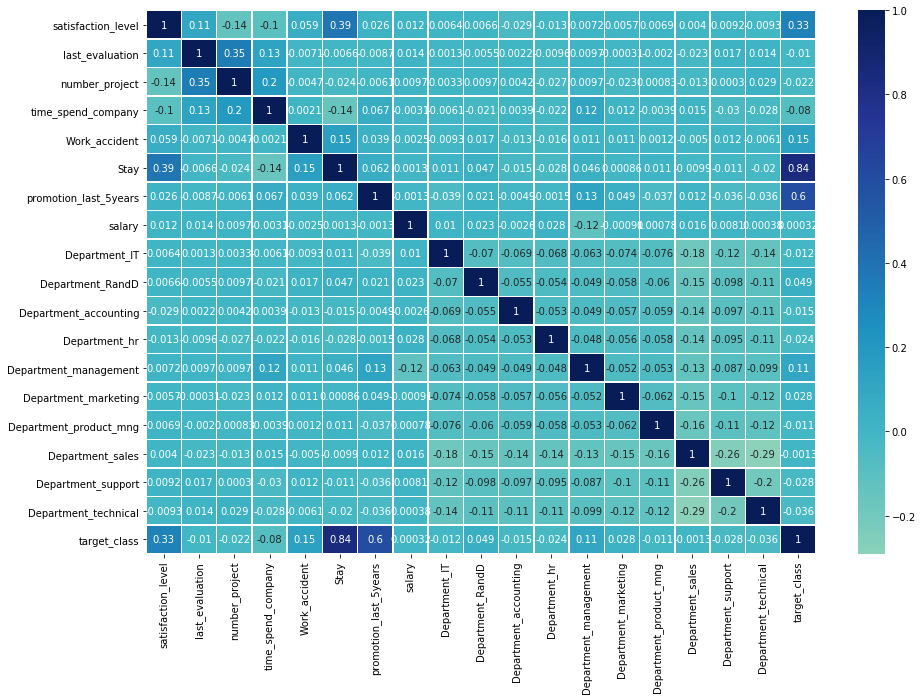

In [25]:
plt.figure(figsize=(15,10))
sns.heatmap(correlation, center=0, annot=True, linewidths=.5, cmap="YlGnBu")

<h2>Invert negative correlation(if available)

<h2>Create new dataframe for churn and uplift

In [26]:
#duplicate result to df_data for calculating MP & MPU
df_data_churn = df_model[['target_class','Stay',treat]]
print(df_data_churn.head())
# df_data_lift = df_model.copy()
df_data_uplift = df_model[['target_class','Stay',treat]]
print(df_data_uplift.head())

    target_class  Stay  promotion_last_5years
id                                           
0              0     0                      0
1              0     0                      0
2              0     0                      0
3              0     0                      0
4              0     0                      0
    target_class  Stay  promotion_last_5years
id                                           
0              0     0                      0
1              0     0                      0
2              0     0                      0
3              0     0                      0
4              0     0                      0


In [27]:
sum(df_data_uplift.Stay ==0)

3571

<h2>Predicting Target Class(Churn Uplift)

In [28]:
#create feature set and labels
X = df_model.drop(['target_class',treat,'Stay'],axis=1)
y = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict = xgb_model.predict(df_model.drop(['target_class',treat,'Stay'],axis=1))
overall_proba=xgb_model.predict_proba(df_model.drop(['target_class',treat,'Stay'],axis=1))
# insert predicted target to uplift dataframe
df_data_uplift['p_target'] = overall_predict
df_model['p_target'] = overall_predict
# assign probabilities to 4 different columns
df_data_uplift['proba_CN'] = overall_proba[:,0] 
df_data_uplift['proba_CR'] = overall_proba[:,1] 
df_data_uplift['proba_TN'] = overall_proba[:,2] 
df_data_uplift['proba_TR'] = overall_proba[:,3]
#calculate uplift score for all customers
df_data_uplift['uplift_score'] = df_data_uplift.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')
#assign it back to main dataframe
df_data_uplift['uplift_score'] = df_data_uplift['uplift_score']

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [29]:
df_data_uplift

,target_class,Stay,promotion_last_5years,p_target,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
id,,,,,,,,,
0,0,0,0,0,0.948248,0.045982,0.002021,0.003748,1.206807
1,0,0,0,0,0.813273,0.158981,0.000704,0.027042,1.622233
2,0,0,0,0,0.990482,0.001525,0.001187,0.006806,1.699926
3,0,0,0,0,0.843032,0.146653,0.000478,0.009836,1.610947
4,0,0,0,0,0.948248,0.045982,0.002021,0.003748,1.206807
...,...,...,...,...,...,...,...,...,...
14994,0,0,0,0,0.945517,0.045850,0.005504,0.003128,0.632268
14995,0,0,0,0,0.949809,0.046058,0.001489,0.002644,1.186976
14996,0,0,0,0,0.949809,0.046058,0.001489,0.002644,1.186976


<h2>Predicting Target (Churn Prediction)

In [30]:
df_model

,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,Stay,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,target_class,p_target
id,,,,,,,,,,,,,,,,,,,,
0,0.38,0.53,2,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0.80,0.86,5,6,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0
2,0.11,0.88,7,4,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0
3,0.72,0.87,5,5,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0.37,0.52,2,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
14995,0.37,0.48,2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
14996,0.37,0.53,2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [31]:
#create feature set and labels
z = df_model.Stay
#splitting train and test groups
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model2 = xgb.XGBClassifier().fit(X_train, z_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict2 = xgb_model2.predict(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
overall_proba2 = xgb_model2.predict_proba(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
# df_data_lift = df_model.copy()
df_data_churn['p_stay'] = overall_predict2
df_model['p_stay'] = overall_predict2
df_data_churn['stay_score'] = overall_proba[:,1] 
df_data_churn['churn_score'] = overall_proba[:,0] 

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

<h2>Rank data from Churn prediction

In [32]:
#choose treatment only
df_data_churn = df_data_churn[df_data_churn[treat] ==1]
print("Ranking data for Churn Prediction")
df_data_churn = df_data_churn.sort_values(by ='stay_score',ascending=True)
df_data_churn

Ranking data for Churn Prediction


,target_class,Stay,promotion_last_5years,p_stay,stay_score,churn_score
id,,,,,,
14498,2,0,1,0,0.008618,0.984573
287,2,0,1,0,0.008618,0.984573
12287,2,0,1,0,0.008618,0.984573
14382,2,0,1,0,0.044909,0.926118
171,2,0,1,0,0.044909,0.926118
...,...,...,...,...,...,...
14008,3,1,1,1,0.978931,0.002703
4553,3,1,1,1,0.981098,0.002809
4555,3,1,1,1,0.982035,0.002835


In [33]:
df_data_churn = df_data_churn.reset_index()

<h2>Rank data from Uplift prediction

In [34]:
#choose treatment only
df_data_uplift = df_data_uplift[df_data_uplift[treat] ==1]
print("Ranking data for Churn Uplift")
df_data_uplift = df_data_uplift.sort_values(by ='uplift_score',ascending=True)
df_data_uplift

Ranking data for Churn Uplift


,target_class,Stay,promotion_last_5years,p_target,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
id,,,,,,,,,
82,2,0,1,1,0.025013,0.906440,0.045662,0.022885,-1.278581
14293,2,0,1,1,0.025013,0.906440,0.045662,0.022885,-1.278581
12082,2,0,1,1,0.025013,0.906440,0.045662,0.022885,-1.278581
5117,3,1,1,1,0.008202,0.945582,0.023546,0.022670,-1.001772
4555,3,1,1,1,0.002835,0.982035,0.003451,0.011679,-0.450384
...,...,...,...,...,...,...,...,...,...
4552,3,1,1,0,0.505199,0.472310,0.000891,0.021600,0.954418
14498,2,0,1,0,0.984573,0.008618,0.003233,0.003576,1.033130
287,2,0,1,0,0.984573,0.008618,0.003233,0.003576,1.033130


In [35]:
sum(df_data_uplift.Stay == 0)

19

In [36]:
df_data_uplift = df_data_uplift.reset_index()

In [37]:
c=0
j=round(len(df_data_churn)/10)
k=round(len(df_model)/10)

#1
b1=200
i1=10
r1_1=(b1-i1-c)
r2_1=(-c)
r3_1=(-i1-c)
r4_1=(b1-c)

#2
b2=100
i2=10
r1_2=(b2-i2-c)
r2_2=(-c)
r3_2=(-i2-c)
r4_2=(b2-c)

#3
b3=100
i3=50
r1_3=(b3-i3-c)
r2_3=(-c)
r3_3=(-i3-c)
r4_3=(b3-c)

profit1=[]
profit2=[]
profit3=[]
profit4=[]
profit5=[]
profit6=[]

uplift1=[]
uplift2=[]
uplift3=[]
uplift4=[]
uplift5=[]
uplift6=[]

churn1=[]
churn2=[]
cum1=[]
cum2=[]
for i in range(10):
    n=i*j
    m=(i+1)*j
    
    #Churn Prediction Variables
    #true predicted churn and retained
    retained = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.Stay[n:m]==1))
    #true predicted churn and rejected
    non_retained = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.Stay[n:m]==0))
    #false predicted churn
    false = sum((df_data_churn.p_stay[n:m]==0)&(df_data_churn.target_class[n:m]==2))
    
    #Churn Uplift Variables
    CN=sum(df_data_uplift.p_target[n:m]==0)
    CR=sum(df_data_uplift.p_target[n:m]==1)
    TN=sum(df_data_uplift.p_target[n:m]==2)
    TR=sum(df_data_uplift.p_target[n:m]==3)
    
    uplift_retained=sum((df_data_uplift.p_target[n:m]==3)&(df_data_uplift.target_class[n:m]==3))
    uplift_non_retained=sum((df_data_uplift.p_target[n:m]==3)&(df_data_uplift.target_class[n:m]==2))
    uplift_false=CR
    
    #Churn Prediction mp 
    mp1=((retained*r1_1)+(non_retained*r2_1)+(false*r3_1))/j
    mp2=((retained*r1_2)+(non_retained*r2_2)+(false*r3_2))/j
    mp3=((retained*r1_3)+(non_retained*r2_3)+(false*r3_3))/j
    
    #Churn Uplift mp
    mp4=((uplift_retained*r1_1)+(uplift_non_retained*r2_1)+(uplift_false*r3_1))/j
    mp5=((uplift_retained*r1_2)+(uplift_non_retained*r2_2)+(uplift_false*r3_2))/j
    mp6=((uplift_retained*r1_3)+(uplift_non_retained*r2_3)+(uplift_false*r3_3))/j

    profit1.append(mp1)
    profit2.append(mp2)
    profit3.append(mp3)
    profit4.append(mp4)
    profit5.append(mp5)
    profit6.append(mp6)
    
    #Churn Prediction Variables
    CP_lift = sum(df_data_churn[j:]['Stay'] ==1)
    CP_non_lift = sum(df_data_churn[j:]['Stay'] ==0)
    CU_lift = sum(df_data_uplift[j:]['Stay'] ==1)
    CU_non_lift = sum(df_data_uplift[j:]['Stay'] ==0)
    
    #Churn Prediction mpu
    mpu1=((CP_lift*r4_1)-(CP_non_lift*i1))/j
    mpu2=((CP_lift*r4_2)-(CP_non_lift*i2))/j
    mpu3=((CP_lift*r4_3)-(CP_non_lift*i3))/j
    
    #Churn Uplift mpu
    mpu4=((CU_lift*r4_1)-(CU_non_lift*i1))/j
    mpu5=((CU_lift*r4_2)-(CU_non_lift*i2))/j
    mpu6=((CU_lift*r4_3)-(CU_non_lift*i3))/j
        
    uplift1.append(mpu1)
    uplift2.append(mpu2)
    uplift3.append(mpu3)
    uplift4.append(mpu4)
    uplift5.append(mpu5)
    uplift6.append(mpu6)
    
    #employee churn rate
    churn_rate1=(TN)/j    
    churn_rate2=(TN+CN)/j    
    churn1.append(churn_rate1)
    churn2.append(churn_rate2)
    
    #employee cumulative uplift
    cum_uplift_rate1=(CR)/j    
    cum_uplift_rate2=(CR+TR)/j    
    cum1.append(churn_rate1)
    cum2.append(churn_rate2)
    
    print("\ncalculating total employees for Q{}({}-{})".format(i+1,n,m))
    print("CN=",CN)
    print("CR=",CR)
    print("TN=",TN)
    print("TR=",TR)   
    print("CP | MP2=(({}*{})+({}*{})+({}*{}) )/{}={}".format(retained,r1_2,non_retained,r2_2,false,r3_2,j,mp2))
    print("CU | MP2=(({}*{})+({}*{})+({}*{}) )/{}={}".format(uplift_retained,r1_2,uplift_non_retained,r2_2,uplift_false,r3_2,j,mp5))
#     print("CP | MPU2=(({}*{})-({}*{}) )/{}={}".format(CP_lift,r4_2,CP_non_lift,r4_2,j,mpu2))
#     print("CU | MPU2=(({}*{})-({}*{}) )/{}={}".format(CU_lift,r4_2,CU_non_lift,r4_2,j,mpu5))


calculating total employees for Q1(0-32)
CN= 0
CR= 32
TN= 0
TR= 0
CP | MP2=((0*90)+(16*0)+(16*-10) )/32=-5.0
CU | MP2=((0*90)+(0*0)+(32*-10) )/32=-10.0

calculating total employees for Q2(32-64)
CN= 0
CR= 32
TN= 0
TR= 0
CP | MP2=((0*90)+(0*0)+(0*-10) )/32=0.0
CU | MP2=((0*90)+(0*0)+(32*-10) )/32=-10.0

calculating total employees for Q3(64-96)
CN= 0
CR= 32
TN= 0
TR= 0
CP | MP2=((0*90)+(0*0)+(0*-10) )/32=0.0
CU | MP2=((0*90)+(0*0)+(32*-10) )/32=-10.0

calculating total employees for Q4(96-128)
CN= 0
CR= 32
TN= 0
TR= 0
CP | MP2=((0*90)+(0*0)+(0*-10) )/32=0.0
CU | MP2=((0*90)+(0*0)+(32*-10) )/32=-10.0

calculating total employees for Q5(128-160)
CN= 0
CR= 28
TN= 0
TR= 4
CP | MP2=((0*90)+(0*0)+(0*-10) )/32=0.0
CU | MP2=((4*90)+(0*0)+(28*-10) )/32=2.5

calculating total employees for Q6(160-192)
CN= 0
CR= 28
TN= 0
TR= 4
CP | MP2=((0*90)+(0*0)+(0*-10) )/32=0.0
CU | MP2=((4*90)+(0*0)+(28*-10) )/32=2.5

calculating total employees for Q7(192-224)
CN= 3
CR= 25
TN= 0
TR= 4
CP | MP2=((0*90)+(0*0

In [38]:
cum_profit1=[]
cum_profit2=[]
cum_profit3=[]
cum_profit4=[]
cum_profit5=[]
cum_profit6=[]
for i in range(1,11):
    cum_profit1.append(sum(profit1[0:i])/i)
for i in range(1,11):
    cum_profit2.append(sum(profit2[0:i])/i)
for i in range(1,11):
    cum_profit3.append(sum(profit3[0:i])/i)
for i in range(1,11):
    cum_profit4.append(sum(profit4[0:i])/i)
for i in range(1,11):
    cum_profit5.append(sum(profit5[0:i])/i)
for i in range(1,11):
    cum_profit6.append(sum(profit6[0:i])/i)
    
cum_uplift1=[]
cum_uplift2=[]
cum_uplift3=[]
cum_uplift4=[]
cum_uplift5=[]
cum_uplift6=[]
for i in range(1,11):
    cum_uplift1.append(sum(uplift1[0:i])/i)
for i in range(1,11):
    cum_uplift2.append(sum(uplift2[0:i])/i)
for i in range(1,11):
    cum_uplift3.append(sum(uplift3[0:i])/i)
for i in range(1,11):
    cum_uplift4.append(sum(uplift4[0:i])/i)
for i in range(1,11):
    cum_uplift5.append(sum(uplift5[0:i])/i)
for i in range(1,11):
    cum_uplift6.append(sum(uplift6[0:i])/i)
    
cum_churn1=[]
cum_churn2=[]
for i in range(10):
    cum_churn1.append(sum(churn1[0:i]))
for i in range(10):
    cum_churn2.append(sum(churn2[0:i]))
    
cum_cum1=[]
cum_cum2=[]
for i in range(10):
    cum_cum1.append(sum(cum1[0:i]))
for i in range(10):
    cum_cum2.append(sum(cum2[0:i]))

Text(0.5, 1.0, 'MP - 1')

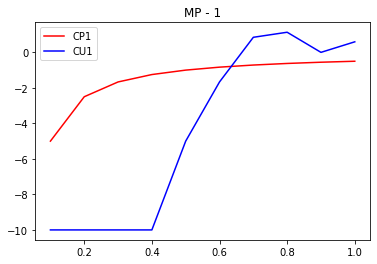

In [39]:
quantile=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
sns.lineplot(x=quantile,y=cum_profit1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_profit4, label='CU1', color='blue')
plt.title('MP - 1')

In [40]:
mean_cp=mean(cum_profit2)
mean_cu=mean(cum_profit5)
print("Predictive Method's Avg MaxProfit =", round(mean_cp,2))
print("Our Method's Avg MaxProfit =", round(mean_cu,2))
print("Our method gain {} times more MaxProfit".format(round(mean_cu/mean_cp,2)))

Predictive Method's Avg MaxProfit = -1.46
Our Method's Avg MaxProfit = -7.14
Our method gain 4.88 times more MaxProfit


Text(0, 0.5, 'Profit per customer')

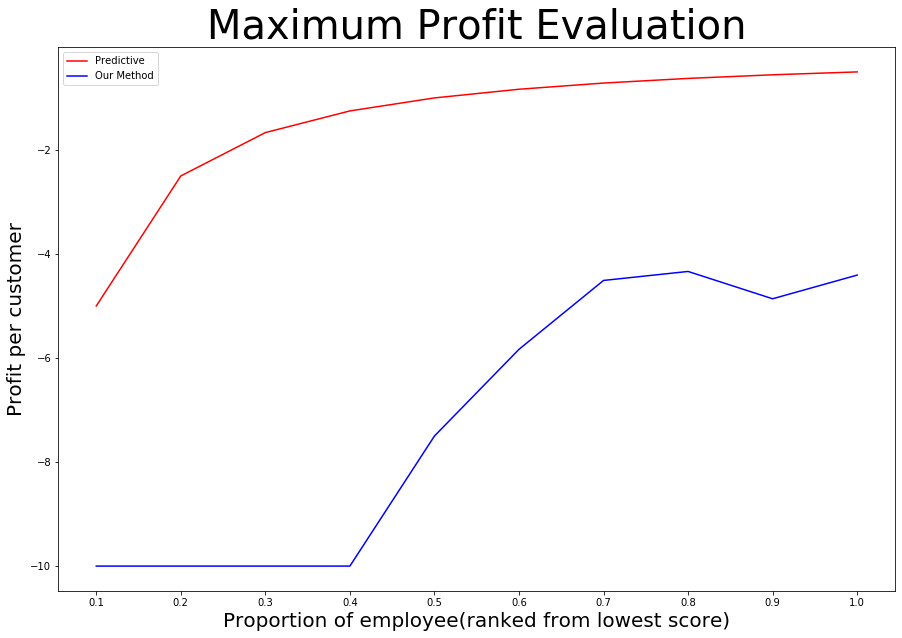

In [41]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_profit2, label='Predictive', color='red')
sns.lineplot(x=quantile,y=cum_profit5, label='Our Method', color='blue')
plt.title('Maximum Profit Evaluation',fontsize=40)
plt.xticks(np.arange(.1,1.1,.1))
plt.xlabel('Proportion of employee(ranked from lowest score)',fontsize=20)
plt.ylabel('Profit per customer',fontsize=20)

Text(0.5, 0, 'Proportion of employee')

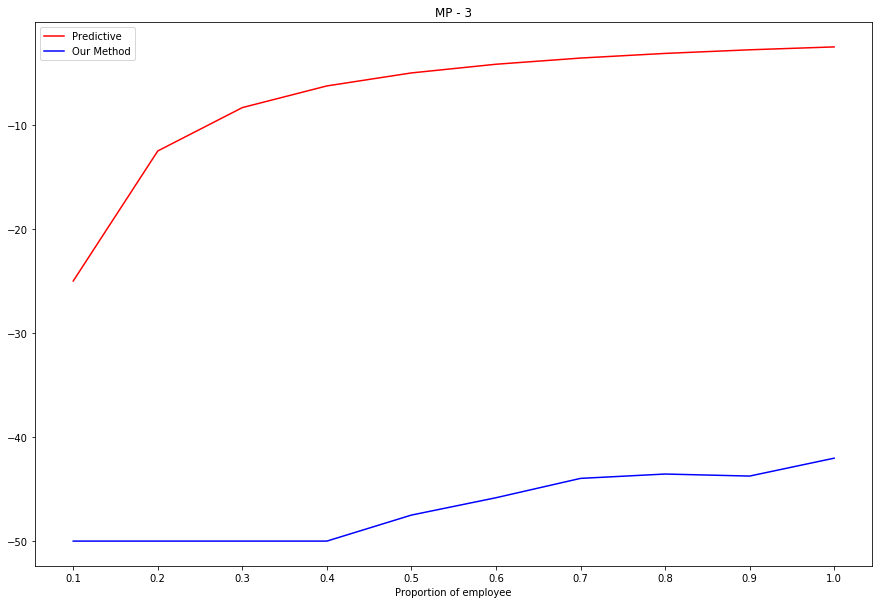

In [42]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_profit3, label='Predictive', color='red')
sns.lineplot(x=quantile,y=cum_profit6, label='Our Method', color='blue')
plt.title('MP - 3')
plt.xticks(np.arange(.1,1.1,.1))
plt.xlabel('Proportion of employee')

Text(0.5, 1.0, 'MP Method')

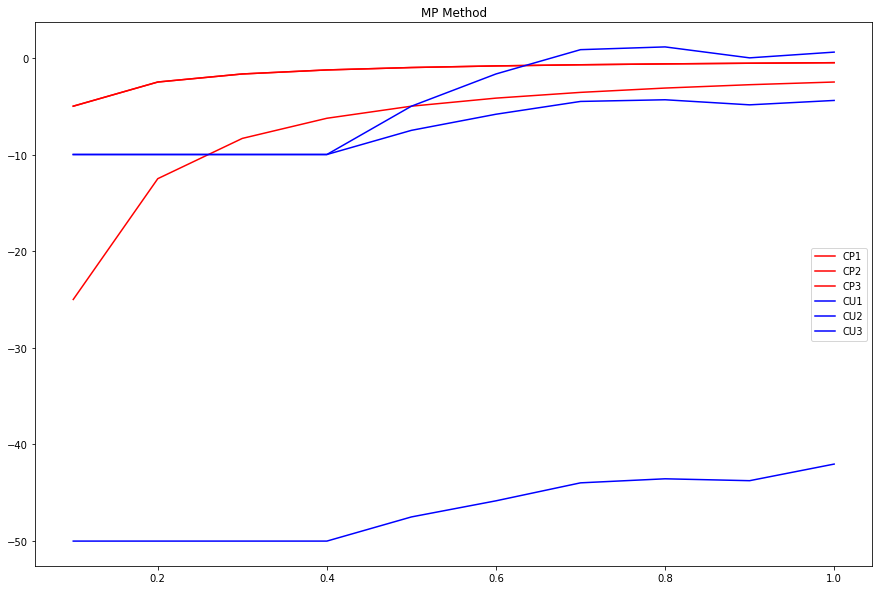

In [43]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_profit1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_profit3, label='CP2', color='red')
sns.lineplot(x=quantile,y=cum_profit2, label='CP3', color='red')
sns.lineplot(x=quantile,y=cum_profit4, label='CU1', color='blue')
sns.lineplot(x=quantile,y=cum_profit5, label='CU2', color='blue')
sns.lineplot(x=quantile,y=cum_profit6, label='CU3', color='blue')
plt.title('MP Method')

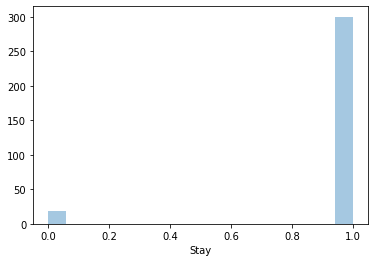

In [44]:
sns.distplot(a=df_data_churn.Stay, hist=True,kde=False)

Text(0.5, 1.0, 'MPU - 1')

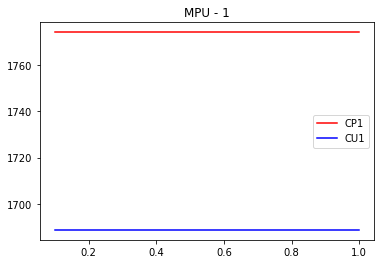

In [45]:
sns.lineplot(x=quantile,y=cum_uplift1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_uplift4, label='CU1', color='blue')
plt.title('MPU - 1')

Text(0.5, 1.0, 'MPU - 2')

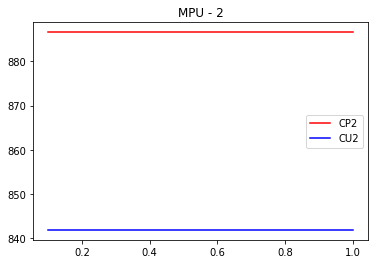

In [46]:
sns.lineplot(x=quantile,y=cum_uplift2, label='CP2', color='red')
sns.lineplot(x=quantile,y=cum_uplift5, label='CU2', color='blue')
plt.title('MPU - 2')

Text(0.5, 1.0, 'MPU - 3')

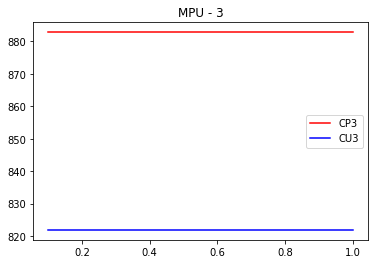

In [47]:
sns.lineplot(x=quantile,y=cum_uplift3, label='CP3', color='red')
sns.lineplot(x=quantile,y=cum_uplift6, label='CU3', color='blue')
plt.title('MPU - 3')

Text(0.5, 1.0, 'MPU Method')

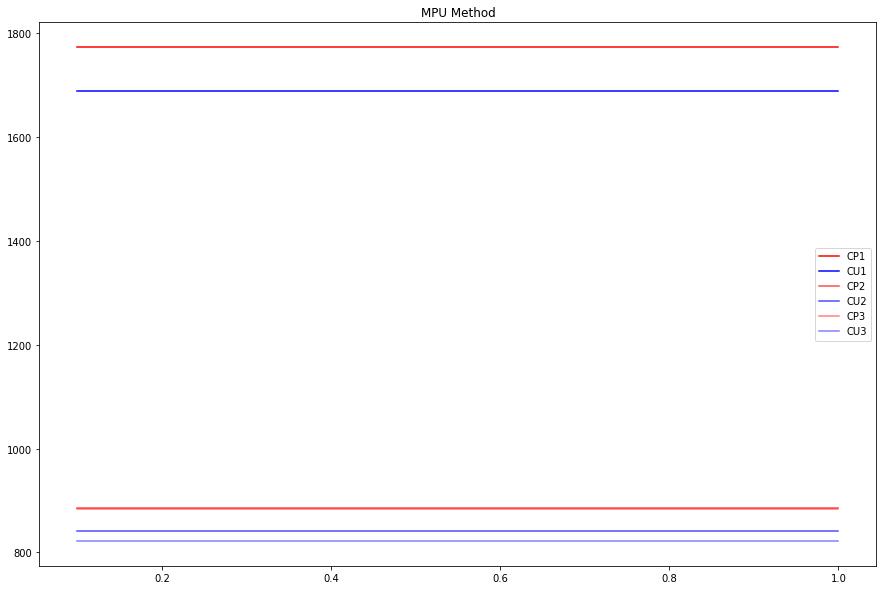

In [48]:
plt.figure(figsize=(15,10))
sns.lineplot(x=quantile,y=cum_uplift1, label='CP1', color='red')
sns.lineplot(x=quantile,y=cum_uplift4, label='CU1', color='blue')
sns.lineplot(x=quantile,y=cum_uplift2, label='CP2', color='red', alpha=0.7)
sns.lineplot(x=quantile,y=cum_uplift5, label='CU2', color='blue', alpha=0.7)
sns.lineplot(x=quantile,y=cum_uplift3, label='CP3', color='red', alpha=0.5)
sns.lineplot(x=quantile,y=cum_uplift6, label='CU3', color='blue', alpha=0.5)
plt.title('MPU Method')

In [49]:
df_data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low


<h2>Pylift

In [50]:
df_data_pylift = df_model.copy()
df_data_pylift.drop(['target_class'], axis=1)
df_data_pylift

,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,Stay,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,target_class,p_target,p_stay
id,,,,,,,,,,,,,,,,,,,,,
0,0.38,0.53,2,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.80,0.86,5,6,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.11,0.88,7,4,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.72,0.87,5,5,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0.37,0.52,2,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14995,0.37,0.48,2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14996,0.37,0.53,2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


pylift modelling

In [51]:
up = TransformedOutcome(df_model, col_treatment=treat, col_outcome='Stay')

In [52]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=46)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   27.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  2.6min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=1,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                                      16, 17, 18, 19, 20],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                  

In [53]:
up.fit(**up.rand_search_.best_params_)

[05:58:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


No handles with labels found to put in legend.


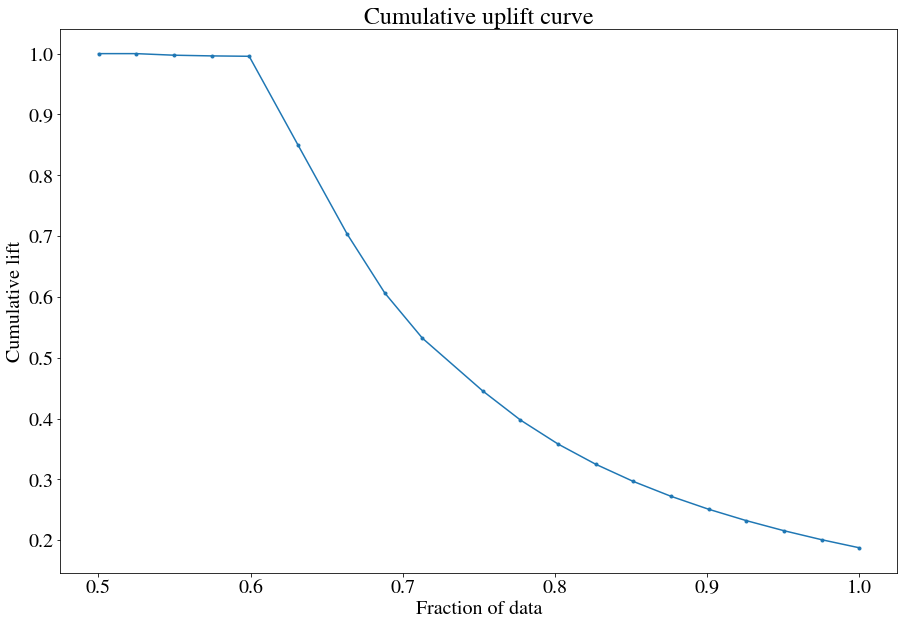

In [54]:
up.plot(plot_type='cuplift')

In [55]:
up.test_results_.q1_cgains

0.5216314665124845

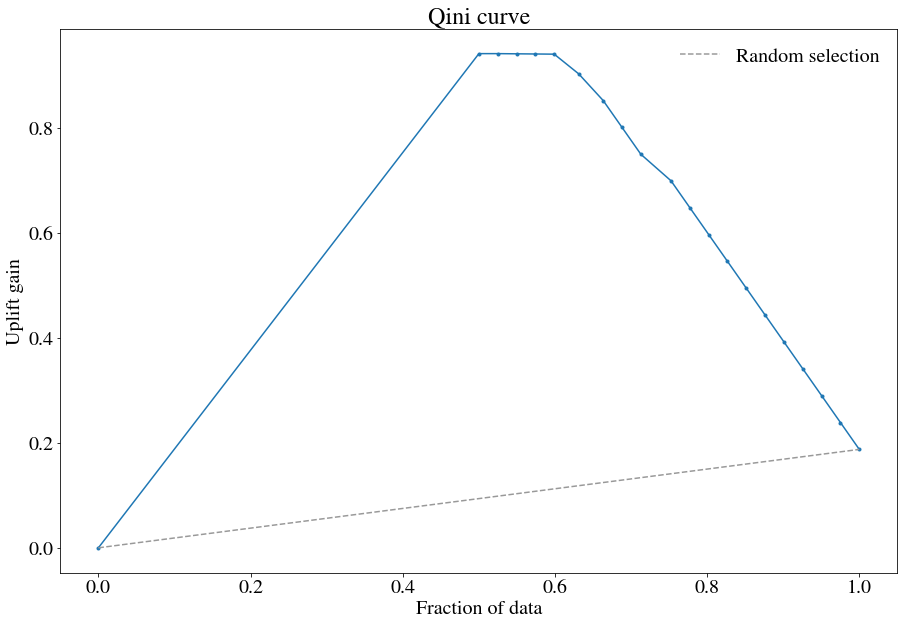

In [56]:
up.plot(plot_type='qini')

[05:58:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 0 finished.
[05:58:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 1 finished.
[05:58:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 2 finished.
[05:58:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 3 finished.
[05:58:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Seed 4 finished.


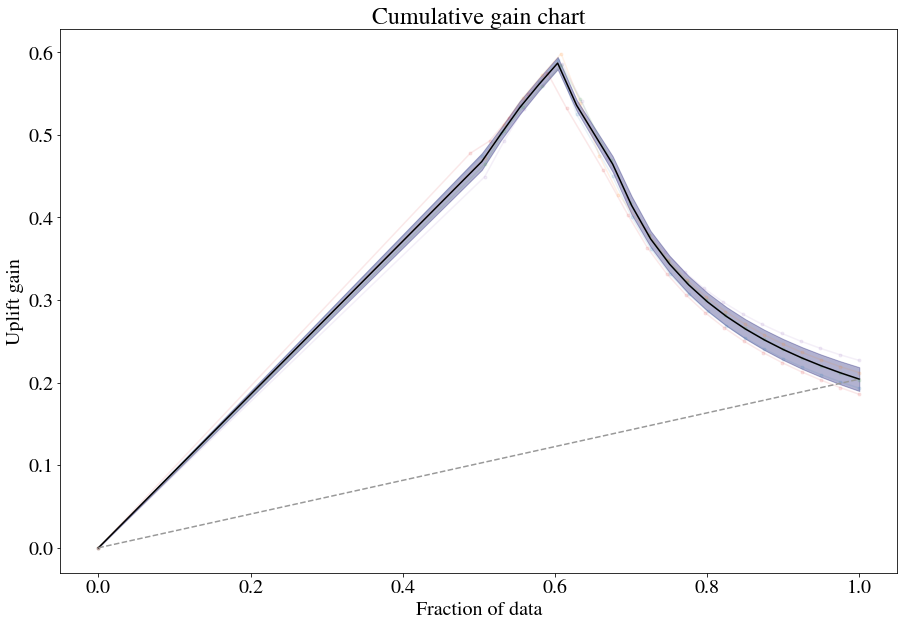

In [57]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);
up.plot(show_shuffle_fits=True)

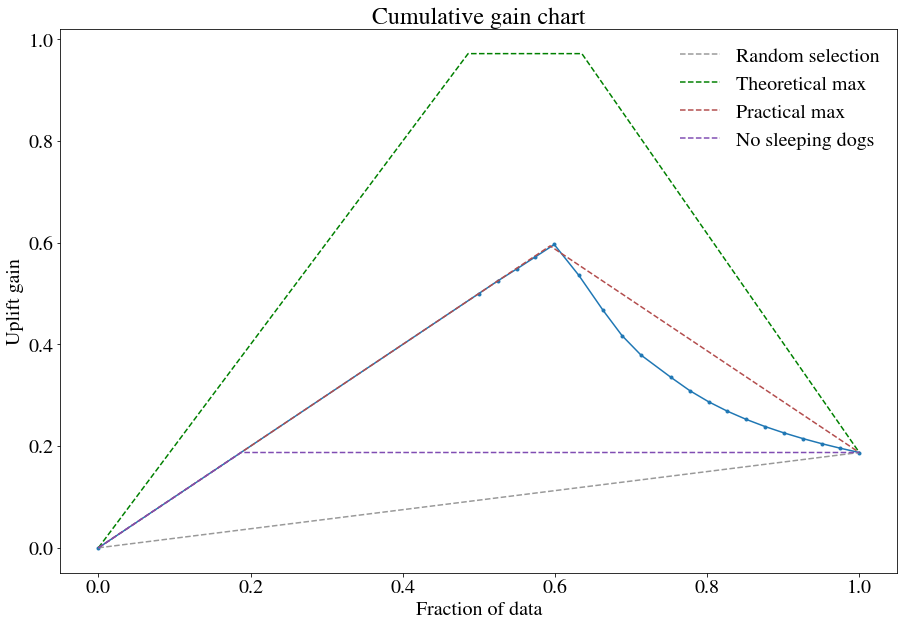

In [58]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

<h1>Causal Lift

In [59]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

In [60]:
cum_lift = calc_cumulative_gains(df_data_churn, 'Stay', 'p_stay', 'stay_score')
cum_lift

,NumCases,NumCorrectPredictions,RunningCorrect,PercentCorrect,CumulativeCorrectBestCase,PercentCorrectBestCase,AvgCase,CumulativeAvgCase,PercentAvgCase,NormalisedPercentAvg,NormalisedPercentWithModel
0,31,31,31,10.333333,31,10.333333,30.0,30.0,10.0,1,1.033333
1,31,31,62,20.666667,62,20.666667,30.0,60.0,20.0,1,1.033333
2,31,31,93,31.000000,93,31.000000,30.0,90.0,30.0,1,1.033333
3,30,30,123,41.000000,123,41.000000,30.0,120.0,40.0,1,1.025000
4,30,30,153,51.000000,153,51.000000,30.0,150.0,50.0,1,1.020000
5,30,30,183,61.000000,183,61.000000,30.0,180.0,60.0,1,1.016667
6,30,27,210,70.000000,213,71.000000,30.0,210.0,70.0,1,1.000000
7,30,30,240,80.000000,243,81.000000,30.0,240.0,80.0,1,1.000000
8,30,30,270,90.000000,273,91.000000,30.0,270.0,90.0,1,1.000000
9,30,30,300,100.000000,303,100.000000,30.0,300.0,100.0,1,1.000000


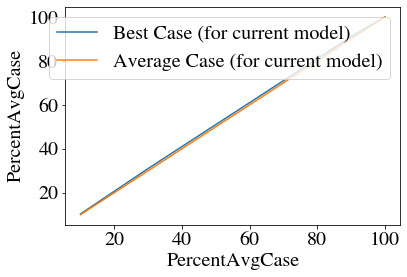

In [61]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_lift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_lift, label="Average Case (for current model)")

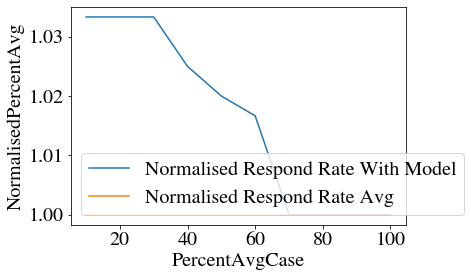

In [62]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_lift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_lift, label="Normalised Respond Rate Avg")

In [63]:
cum_uplift = calc_cumulative_gains(df_data_uplift, 'target_class', 'p_target', 'uplift_score')
cum_uplift

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


,NumCases,NumCorrectPredictions,RunningCorrect,PercentCorrect,CumulativeCorrectBestCase,PercentCorrectBestCase,AvgCase,CumulativeAvgCase,PercentAvgCase,NormalisedPercentAvg,NormalisedPercentWithModel
0,29,0,0,NaN,29,100,0.0,0.0,NaN,1,NaN
1,29,0,0,NaN,58,100,0.0,0.0,NaN,1,NaN
2,29,0,0,NaN,87,100,0.0,0.0,NaN,1,NaN
3,29,0,0,NaN,116,100,0.0,0.0,NaN,1,NaN
4,29,0,0,NaN,145,100,0.0,0.0,NaN,1,NaN
5,28,0,0,NaN,173,100,0.0,0.0,NaN,1,NaN
6,28,0,0,NaN,201,100,0.0,0.0,NaN,1,NaN
7,28,0,0,NaN,229,100,0.0,0.0,NaN,1,NaN
8,28,0,0,NaN,257,100,0.0,0.0,NaN,1,NaN
9,28,0,0,NaN,285,100,0.0,0.0,NaN,1,NaN


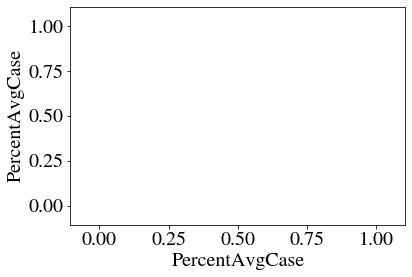

In [64]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_uplift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_uplift, label="Average Case (for current model)")

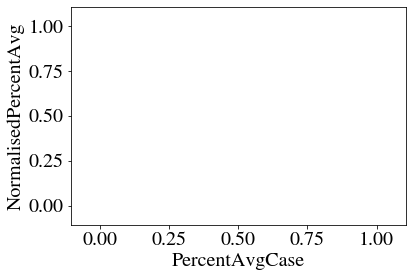

In [65]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_uplift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_uplift, label="Normalised Respond Rate Avg")

In [66]:
#create feature set and labels
df_model_causal = df_model.drop(['target_class','p_stay','p_target'],axis=1)
df_model_causal.rename(columns={treat:'Treatment','Stay':'Outcome'}, inplace=True)
df_model_causal

,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,Outcome,Treatment,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,TransformedOutcome
id,,,,,,,,,,,,,,,,,,,
0,0.38,0.53,2,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,-0
1,0.80,0.86,5,6,0,0,0,2,0,0,0,0,0,0,0,1,0,0,-0
2,0.11,0.88,7,4,0,0,0,2,0,0,0,0,0,0,0,1,0,0,-0
3,0.72,0.87,5,5,0,0,0,1,0,0,0,0,0,0,0,1,0,0,-0
4,0.37,0.52,2,3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-0
14995,0.37,0.48,2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-0
14996,0.37,0.53,2,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-0


In [67]:
#splitting train and test groups
train_df, test_df = train_test_split(df_model_causal, test_size=0.2, random_state=42, stratify=df_model_causal['Treatment'])

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\kedro\io\core.py:682: DeprecationWarning: PickleLocalDataSet will be deprecated in future releases. Please refer to replacement datasets in kedro.extras.datasets.
  DeprecationWarning,
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\kedro\io\core.py:682: DeprecationWarning: CSVLocalDataSet will be deprecated in future releases. Please refer to replacement datasets in kedro.extras.datasets.
  DeprecationWarning,


[2020-03-12 05:58:41,707|causallift.context.flexible_context|INFO] Run pipeline (tags: ['011_bundle_train_and_test_data'], SequentialRunner, only_missing: False)
[2020-03-12 05:58:41,726|kedro.pipeline.node|INFO] Running node: bundle_train_and_test_data([args_raw,test_df,train_df]) -> [df_00]
[2020-03-12 05:58:41,737|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2020-03-12 05:58:41,738|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-03-12 05:58:41,744|causallift.context.flexible_context|INFO] Run pipeline (tags: ['121_prepare_args', '131_treatment_fractions_', '141_initialize_model'], SequentialRunner, only_missing: False)
[2020-03-12 05:58:41,758|kedro.pipeline.node|INFO] Running node: impute_cols_features([args_raw,df_00]) -> [args_intermediate]
[2020-03-12 05:58:41,760|kedro.runner.sequential_runner|INFO] Completed 1 out of 3 tasks
[2020-03-12 05:58:41,765|kedro.pipeline.node|INFO] Running node: treatment_fractions_([args_raw,

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\kedro\pipeline\pipeline.py:198: DeprecationWarning: `name` parameter is deprecated for the `Pipeline` constructor, use `Pipeline.tag` method instead
  DeprecationWarning,


[2020-03-12 05:58:44,968|causallift.nodes.estimate_propensity|INFO] ### Best parameter for logistic regression:
{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'warm_start': False}
[2020-03-12 05:58:44,968|causallift.nodes.estimate_propensity|INFO] 
## Coefficients of logistic regression:


,satisfaction_level,last_evaluation,number_project,time_spend_company,Work_accident,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,TransformedOutcome
coefficient,0.0,0.0,-0.928454,-0.919889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.095483


[2020-03-12 05:58:45,000|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2020-03-12 05:58:45,002|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-03-12 05:58:45,012|causallift.context.flexible_context|INFO] Run pipeline (tags: ['221_estimate_propensity'], SequentialRunner, only_missing: False)
[2020-03-12 05:58:45,027|kedro.pipeline.node|INFO] Running node: estimate_propensity([args,df_00,propensity_model]) -> [df_01]
[2020-03-12 05:58:45,059|causallift.nodes.estimate_propensity|INFO] 
### Histogram of propensity score for train and test data:


C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\kedro\pipeline\pipeline.py:198: DeprecationWarning: `name` parameter is deprecated for the `Pipeline` constructor, use `Pipeline.tag` method instead
  DeprecationWarning,


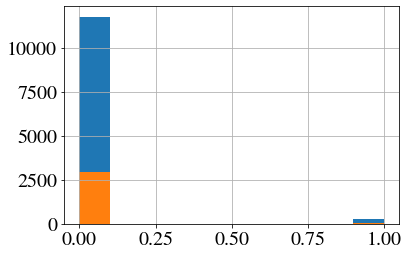

[2020-03-12 05:58:45,357|causallift.nodes.estimate_propensity|INFO] 
### Score Table for logistic regression to calculate propensity score:


,# samples,# classes,accuracy,precision,recall,f1,roc_auc,observed conversion rate,predicted conversion rate
train,11999,2,0.998667,1.0,0.937255,0.967611,0.968627,0.021252,0.019918
test,3000,2,0.999000,1.0,0.953125,0.976000,0.976562,0.021333,0.020333


[2020-03-12 05:58:45,402|causallift.nodes.estimate_propensity|INFO] 
### Confusion Matrix for Train:


,Pred_0,Pred_1
True_0,11744,0
True_1,16,239


[2020-03-12 05:58:45,427|causallift.nodes.estimate_propensity|INFO] 
### Confusion Matrix for Test:


,Pred_0,Pred_1
True_0,2936,0
True_1,3,61


[2020-03-12 05:58:45,461|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2020-03-12 05:58:45,463|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2020-03-12 05:58:45,469|causallift.causal_lift|INFO] ### Treatment fraction in train dataset: 0.021251770980915075
[2020-03-12 05:58:45,471|causallift.causal_lift|INFO] ### Treatment fraction in test dataset: 0.021333333333333333
[2020-03-12 05:58:45,477|causallift.context.flexible_context|INFO] Run pipeline (tags: ['311_fit', '312_bundle_2_models'], SequentialRunner, only_missing: False)
[2020-03-12 05:58:45,495|kedro.pipeline.node|INFO] Running node: model_for_treated_fit([args,df_01]) -> [treated__model_dict]
[2020-03-12 05:58:45,497|causallift.nodes.model_for_each|INFO] 

## Model for Treatment = 1.0
[2020-03-12 05:58:45,517|causallift.nodes.model_for_each|WARNING] [Warning] Propensity scores below 0.01 were clipped.
[2020-03-12 05:58:45,519|causallift.nodes.model_for_each|WARNING] [Warning

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\kedro\pipeline\pipeline.py:198: DeprecationWarning: `name` parameter is deprecated for the `Pipeline`

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields TransformedOutcome

In [68]:
""" Step 0. Import CausalLift
"""

from causallift import CausalLift

""" Step 1. Feed datasets and optionally compute estimated propensity scores
using logistic regression if set enable_ipw = True.
"""


cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

""" Step 2. Train 2 classification models (XGBoost) for treated and untreated
samples independently and compute estimated CATE (Conditional Average Treatment
Effect), ITE (Individual Treatment Effect), or uplift score.
"""

train_df, test_df = cl.estimate_cate_by_2_models()

""" Step 3. Estimate how much conversion rate will increase by selecting treatment
(campaign) targets as recommended by the uplift modeling.
"""

estimated_effect_df = cl.estimate_recommendation_impact()

In [ ]:
estimated_effect_df